# Setup

In [1]:
import os
import sys
import glob
from os.path import abspath
os.environ['SPARK_HOME'] = '/home/chiara/Documenti/BigData/spark-3.5.0-bin-hadoop3'
os.environ['HADOOP_HOME'] = '/home/chiara/Documenti/BigData/spark-3.5.0-bin-hadoop3'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'

In [2]:
spark_python = os.path.join(os.environ.get('SPARK_HOME',None),'python')
py4j = glob.glob(os.path.join(spark_python,'lib','py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python,'graphframes.zip'))[0]
sys.path[:0]=[spark_python,py4j]
sys.path[:0]=[spark_python,graphf]
os.environ['PYTHONPATH']=py4j+os.pathsep+graphf

In [3]:
import findspark
findspark.init()
findspark.find()

'/home/chiara/Documenti/BigData/spark-3.5.0-bin-hadoop3'

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Counting Triangles").enableHiveSupport().getOrCreate()


24/02/19 13:02:26 WARN Utils: Your hostname, laltro resolves to a loopback address: 127.0.1.1; using 192.168.1.16 instead (on interface wlo1)
24/02/19 13:02:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/19 13:02:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt

# Parsing Dataset File

In [6]:
with open('dataset/Wiki-Vote.txt','r') as f:
    content = f.readlines()

edges_list = list(filter( lambda x: not x.startswith('#') ,content))
edges = list(map(lambda x: tuple(x.split('\t')), edges_list))
edges_tuples = list(map(lambda x: (int(x[0]), int(x[1].replace('\n',''))), edges))

In [7]:
from pyspark.sql.types import IntegerType, Row

list1, list2 = zip(*edges_tuples)
nodes = list(set(list1 + list2))
nodes_tuple = [Row(x) for x in nodes]

In [8]:
from pyspark.sql.functions import col, collect_list

vertices = spark.createDataFrame(nodes, IntegerType())
vertices = vertices.withColumnRenamed('value','id')
edges_n = spark.createDataFrame(edges_tuples,["src", "dst"],IntegerType())

edges_inverted = edges_n.filter(edges_n.src > edges_n.dst)
edges_normal = edges_n.filter(edges_n.src <= edges_n.dst)
edges_normal2 = edges_inverted.select(col('dst').alias('src'),col('src').alias('dst'))
edges = edges_normal.union(edges_normal2)

# Preprocess

In [11]:
from pyspark.sql.functions import hash

hashed_vertices = vertices.withColumn("id_hash", hash("id"))
hashed_edges = edges.withColumn("edge_hash", hash("src","dst")) #hash_table1True

In [12]:
hashed_edges.count()

103689

### Order edges by src and then by dst

In [13]:
hashed_edges = hashed_edges.orderBy('src','dst')
hashed_edges.show()

+---+---+-----------+
|src|dst|  edge_hash|
+---+---+-----------+
|  3|  6|  103692146|
|  3| 10|  497451373|
|  3| 14|-1986372784|
|  3| 17|  857407947|
|  3| 19| -897196145|
|  3| 20| 1301826884|
|  3| 24|-1434889980|
|  3| 25|-1319766737|
|  3| 26| -137684243|
|  3| 28| -382845849|
|  3| 28| -382845849|
|  3| 29|-1929999608|
|  3| 30| -706060392|
|  3| 34| -731846847|
|  3| 35| -576134015|
|  3| 39|  111694818|
|  3| 41| 1257747420|
|  3| 46|-1529083522|
|  3| 47|-1127221733|
|  3| 54|   12486257|
+---+---+-----------+
only showing top 20 rows



### Find nodes degrees

In [81]:
graph = GraphFrame(vertices, edges)

In [15]:
def plot_undirected_graph(edge_list):
    plt.figure(figsize=(20,20))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=3500)

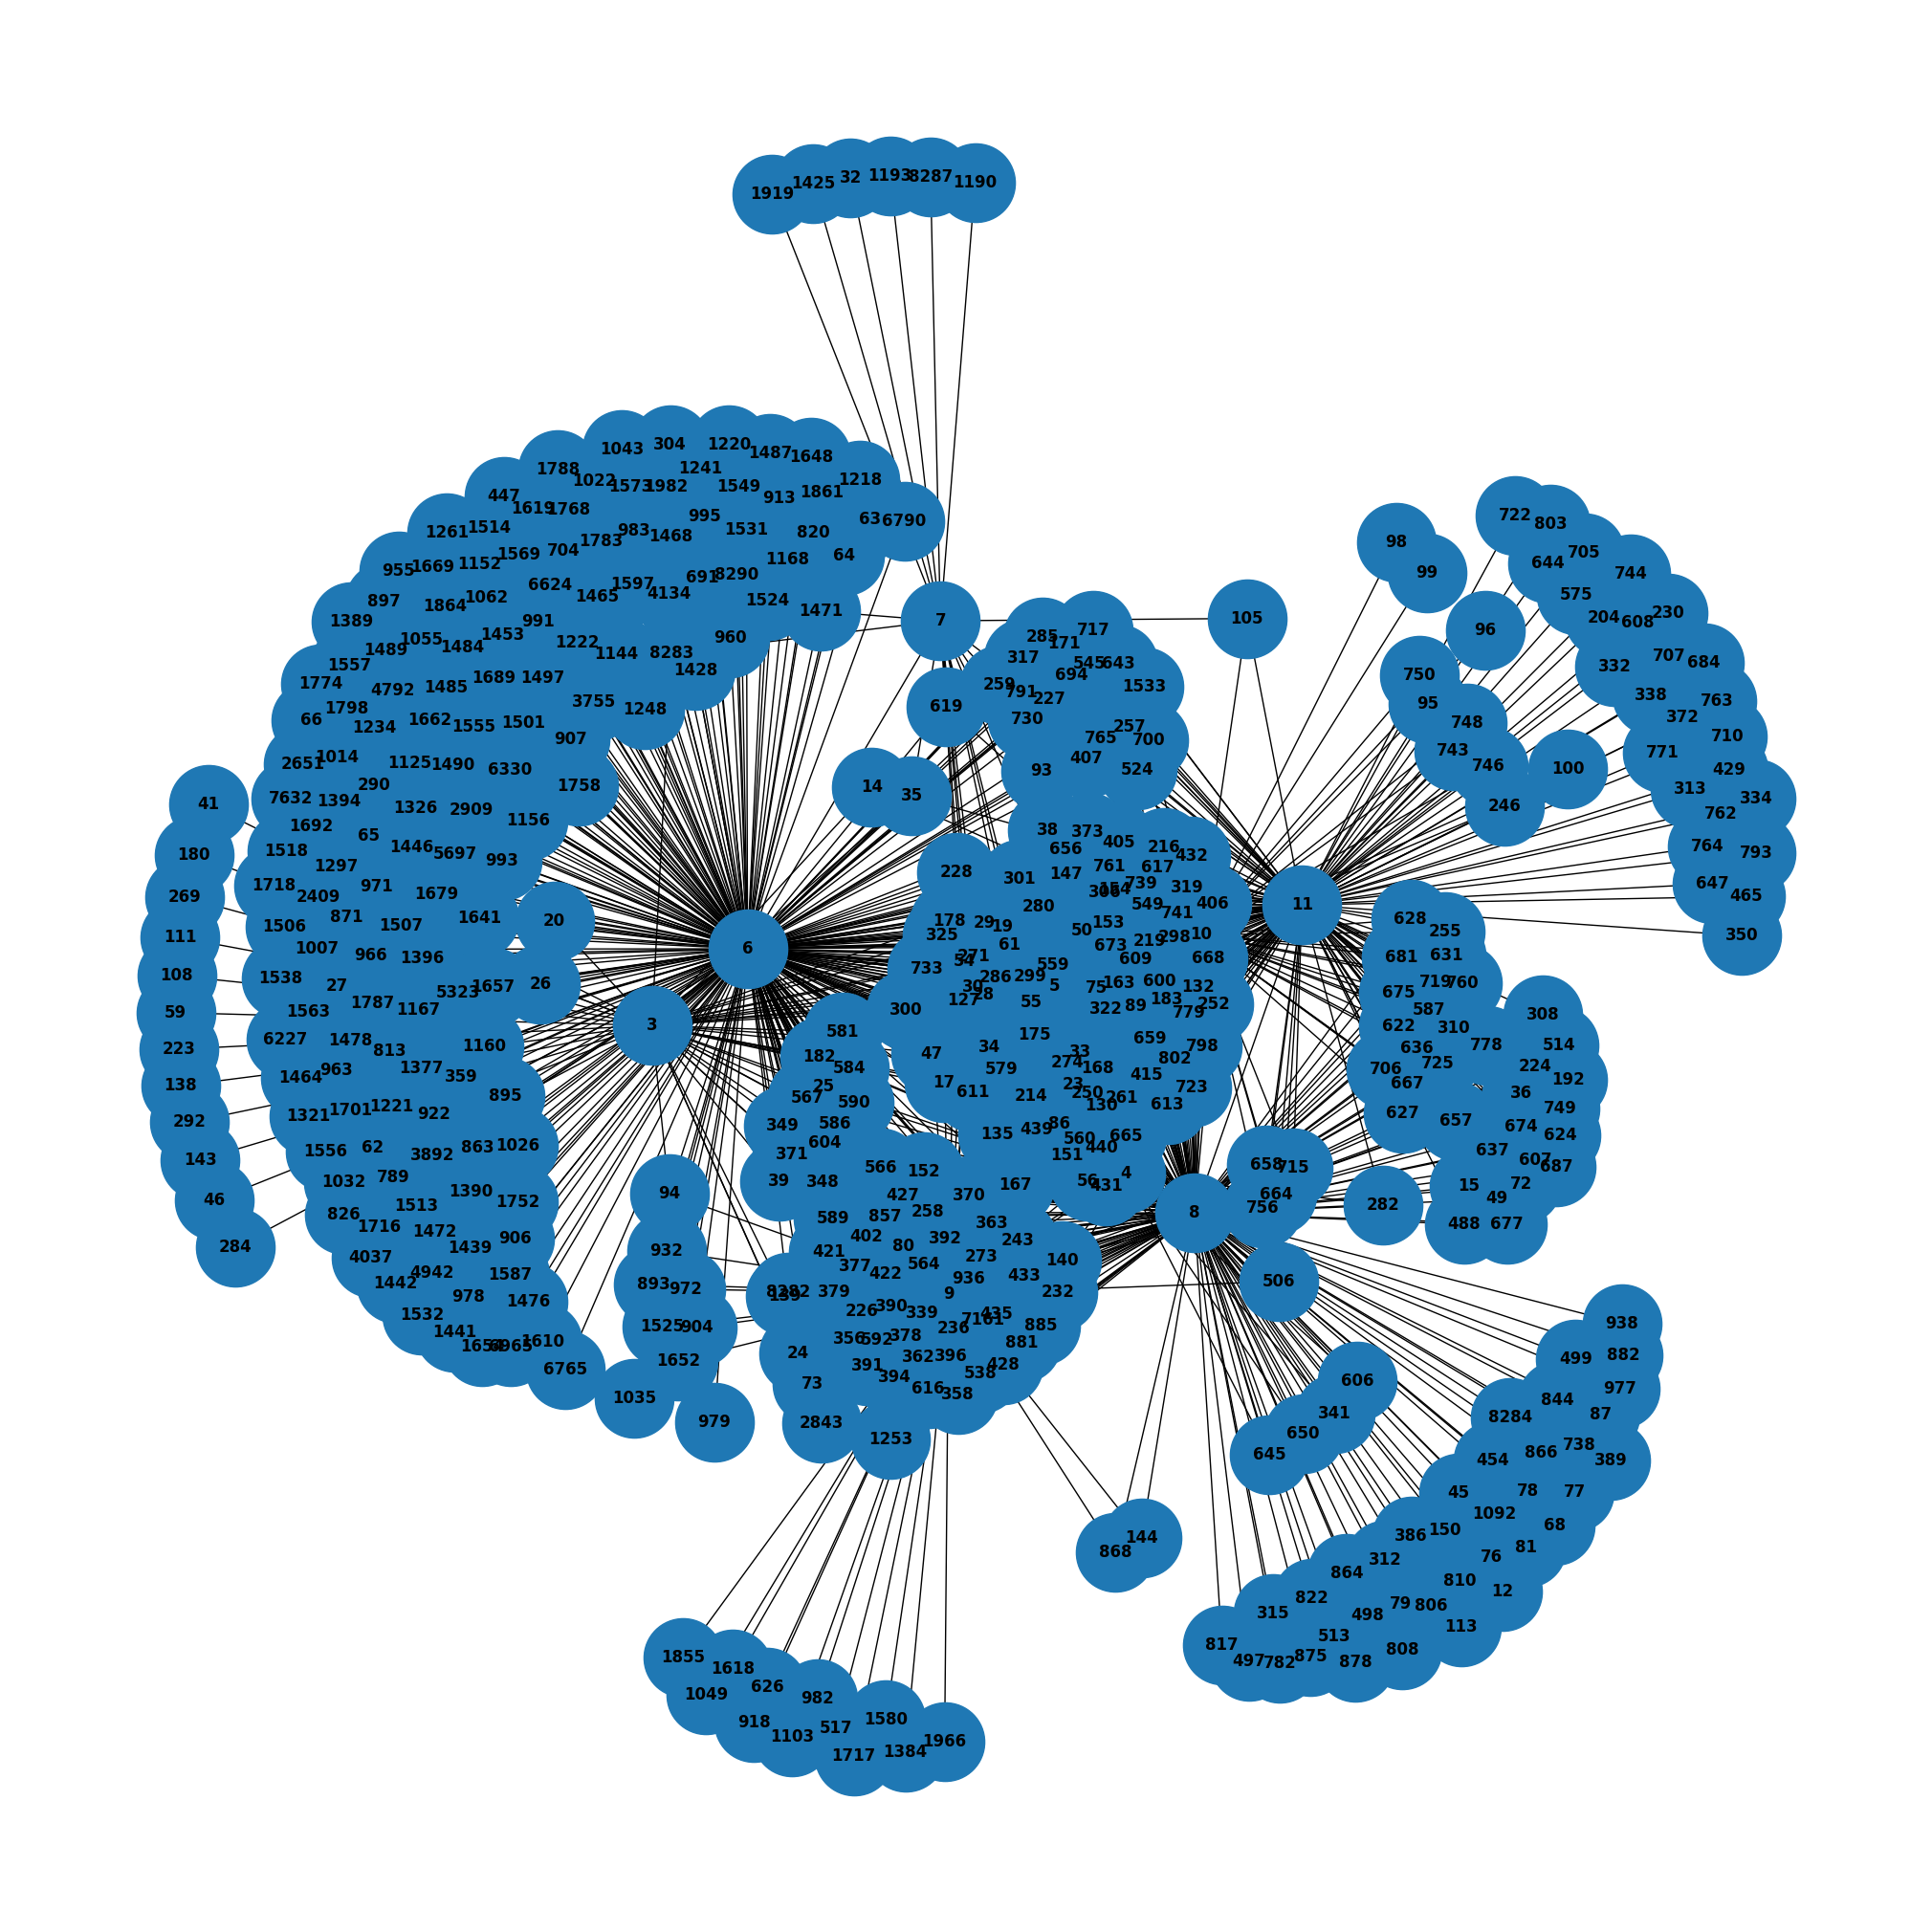

In [16]:
plot_undirected_graph(hashed_edges)

### Get Hash-Tables

In [17]:
hashed_vertices = hashed_vertices.join(graph.degrees, 'id')

In [18]:
hashed_vertices.show()

+----+-----------+------+
|  id|    id_hash|degree|
+----+-----------+------+
|  29| -359179259|   191|
|1697| -551962519|   118|
|  26|-1223696181|    95|
|3506| 1758663860|    31|
|7279|  677347517|    94|
|7225|  133557821|   121|
|1950| -155505317|     5|
|1360| -850885534|    75|
|3800| 1817704906|    68|
|3806| -291460327|    83|
|3015| 1378773279|    94|
|  65| 1103002004|     2|
|7544| 1053883755|    57|
|3106|-1012679861|    62|
|3009| 1850688549|   105|
| 730|-1965592663|    80|
|2909| 1698401074|   122|
| 938| -809457674|    36|
|1127| -328389399|    95|
|2517| 1310710431|    88|
+----+-----------+------+
only showing top 20 rows



In [19]:
hashed_vertices = hashed_vertices.orderBy('degree','id')
hashed_vertices.show()

+---+-----------+------+
| id|    id_hash|degree|
+---+-----------+------+
| 52| -525511556|     1|
| 63| -974635281|     1|
| 82|-1553747671|     1|
| 84| -518928091|     1|
| 85|-1540204797|     1|
| 88| 1395177486|     1|
|112|  839133079|     1|
|114| -603498699|     1|
|117|  542402473|     1|
|118|  664348778|     1|
|119|-1821942227|     1|
|123|   85273170|     1|
|137| -914795597|     1|
|141| -288832847|     1|
|146|  138698241|     1|
|149| -272975425|     1|
|159|-1546224379|     1|
|160| 1642837935|     1|
|174|  491128187|     1|
|189| 1466639083|     1|
+---+-----------+------+
only showing top 20 rows



## Heavy-hitters

### Find heavy-hitters

In [20]:
m = graph.edges.count()

In [21]:
m

103689

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
import math 

hitters = udf(lambda x: x >= math.sqrt(m),BooleanType())

In [23]:
heavy_hitters = hashed_vertices.select('id', 'id_hash', 'degree', hitters('degree').alias('isHeavyHitter'))

In [24]:
heavy_hitters.show()

+---+-----------+------+-------------+
| id|    id_hash|degree|isHeavyHitter|
+---+-----------+------+-------------+
| 52| -525511556|     1|        false|
| 63| -974635281|     1|        false|
| 82|-1553747671|     1|        false|
| 84| -518928091|     1|        false|
| 85|-1540204797|     1|        false|
| 88| 1395177486|     1|        false|
|112|  839133079|     1|        false|
|114| -603498699|     1|        false|
|117|  542402473|     1|        false|
|118|  664348778|     1|        false|
|119|-1821942227|     1|        false|
|123|   85273170|     1|        false|
|137| -914795597|     1|        false|
|141| -288832847|     1|        false|
|146|  138698241|     1|        false|
|149| -272975425|     1|        false|
|159|-1546224379|     1|        false|
|160| 1642837935|     1|        false|
|174|  491128187|     1|        false|
|189| 1466639083|     1|        false|
+---+-----------+------+-------------+
only showing top 20 rows



### Verify all sets of three heavy-hitter nodes

In [25]:
heavy_hitters = heavy_hitters.filter(heavy_hitters.isHeavyHitter == True).select('id')

In [26]:
heavy_hitters.show()

+----+
|  id|
+----+
|2625|
| 173|
|5022|
|5697|
|2576|
|3447|
|2256|
|4967|
|5800|
|3642|
|1305|
| 311|
|5189|
|2658|
|1297|
|3453|
| 789|
|1133|
|2398|
|2972|
+----+
only showing top 20 rows



In [27]:
heavy_hitters.count()

45

In [28]:
combinations = heavy_hitters.alias('n1') \
            .join(heavy_hitters.alias('n2'), col('n1.id') < col('n2.id'))\
            .join(heavy_hitters.alias('n3'), col('n2.id') < col('n3.id'))\
            .select(col('n1.id').alias('node1'), col('n2.id').alias('node2'), col('n3.id').alias('node3'))\
            .distinct()

In [29]:
combinations.count()

14190

In [30]:
combinations.orderBy('node1','node2','node3').show()

+-----+-----+-----+
|node1|node2|node3|
+-----+-----+-----+
|   11|   15|  173|
|   11|   15|  311|
|   11|   15|  457|
|   11|   15|  737|
|   11|   15|  766|
|   11|   15|  789|
|   11|   15|  993|
|   11|   15| 1133|
|   11|   15| 1151|
|   11|   15| 1166|
|   11|   15| 1297|
|   11|   15| 1305|
|   11|   15| 1374|
|   11|   15| 1549|
|   11|   15| 1608|
|   11|   15| 2237|
|   11|   15| 2256|
|   11|   15| 2328|
|   11|   15| 2398|
|   11|   15| 2485|
+-----+-----+-----+
only showing top 20 rows



In [31]:
heavy_hitters_triangles = combinations.alias('c') \
    .join(hashed_edges.alias('e'), (col("c.node1") == col("e.src")) & (col("c.node2") == col("e.dst"))) \
    .join(hashed_edges, (col("c.node2") == col("e.src")) & (col("c.node3") == col("e.dst"))) \
    .join(hashed_edges, (col("c.node1") == col("e.src")) & (col("c.node3") == col("e.dst"))) \
    .select(col('c.node1'), col('c.node2'), col('c.node3'))

In [32]:
heavy_hitters_triangles.count()

0

## Non heavy-hitters

### Find non-heavy-hitters edges

In [33]:
selected_edges = edges.alias('e')\
                .join(heavy_hitters.alias('h_src'), col('e.src') == col('h_src.id'), 'left_outer')\
                .filter((col('h_src.id').isNull()))\
                .select('e.src','e.dst')

In [34]:
selected_edges.count()

87659

### For each edge find adjacent nodes minor then src, and check if exist the edge (dst, adjacent_node)

In [55]:
selected_edges.orderBy('src','dst').show()

+---+---+
|src|dst|
+---+---+
|  3|  6|
|  3| 10|
|  3| 14|
|  3| 17|
|  3| 19|
|  3| 20|
|  3| 24|
|  3| 25|
|  3| 26|
|  3| 28|
|  3| 28|
|  3| 29|
|  3| 30|
|  3| 34|
|  3| 35|
|  3| 39|
|  3| 41|
|  3| 46|
|  3| 47|
|  3| 54|
+---+---+
only showing top 20 rows



In [61]:
adjacency_check = selected_edges.alias('e1')\
                .join(selected_edges.alias('e2'), (col('e1.src') == col('e2.src')) & (col('e1.dst') < col('e2.dst')))\
                .select(col('e1.src').alias('v1'), col('e1.dst').alias('v2'), col('e2.dst').alias('v3')).distinct()

In [69]:
triangles = adjacency_check.alias('e1')\
                .join(selected_edges.alias('e2'), (col('e1.v2') == col('e2.src')) & (col('e1.v3') == col('e2.dst')))\
                .select(col('e1.v1').alias('v1'), col('e1.v2').alias('v2'), col('e1.v3').alias('v3'))

In [78]:
triangles.count()

331056

In [77]:
triangles.show()

+---+---+----+
| v1| v2|  v3|
+---+---+----+
|  3|108|8283|
|  3| 25| 590|
|  3|139| 611|
|  4|  8| 232|
|  4| 28| 130|
|  6|  8| 232|
|  6| 19|  61|
|  6| 23| 656|
|  6|151|1248|
|  6|280| 407|
|  6|356|1428|
|  6|407|1758|
|  6|704|1501|
|  6|826|1377|
|  6|826|1377|
|  6|826|1679|
|  6|871|1377|
|  6|871|1377|
|  6|871|1441|
|  6|978|1718|
+---+---+----+
only showing top 20 rows



### Example

In [76]:
edges.filter((edges.src == 3) & (edges.dst == 108)).show()
edges.filter((edges.src == 3) & (edges.dst == 8283)).show()
edges.filter((edges.src == 108) & (edges.dst == 8283)).show()

+---+---+
|src|dst|
+---+---+
|  3|108|
+---+---+

+---+----+
|src| dst|
+---+----+
|  3|8283|
+---+----+

+---+----+
|src| dst|
+---+----+
|108|8283|
+---+----+



# QUERY SQL FOR FINDING TRIANGLES

In [36]:
e1 = hashed_edges.alias('e1')
e2 = hashed_edges.alias('e2')
e3 = hashed_edges.alias('e3')

In [37]:
e1.show()

+---+---+-----------+
|src|dst|  edge_hash|
+---+---+-----------+
|  3|  6|  103692146|
|  3| 10|  497451373|
|  3| 14|-1986372784|
|  3| 17|  857407947|
|  3| 19| -897196145|
|  3| 20| 1301826884|
|  3| 24|-1434889980|
|  3| 25|-1319766737|
|  3| 26| -137684243|
|  3| 28| -382845849|
|  3| 28| -382845849|
|  3| 29|-1929999608|
|  3| 30| -706060392|
|  3| 34| -731846847|
|  3| 35| -576134015|
|  3| 39|  111694818|
|  3| 41| 1257747420|
|  3| 46|-1529083522|
|  3| 47|-1127221733|
|  3| 54|   12486257|
+---+---+-----------+
only showing top 20 rows



In [38]:
from pyspark.sql.functions import col

result = e1.join(e2, col("e1.src") == col("e2.src")) \
    .join(e3, (col("e1.dst") == col("e3.src")) & (col("e2.dst") == col("e3.dst"))) \
    .select(col("e1.src"), col("e1.dst"), col("e2.dst"))


In [39]:
result.count()

790532

# API GraphFrames

In [82]:
results = graph.triangleCount()
results.select("id", "count").show()
results.count()

+---+-----+
| id|count|
+---+-----+
| 12|  197|
| 22|    0|
| 13|   12|
|  6| 3143|
| 16|   23|
|  3|  280|
| 20| 1078|
|  5|   88|
| 19|  482|
| 15| 4847|
|  9|  321|
| 17|  156|
|  4|   95|
|  8| 2294|
| 23|  661|
|  7|   42|
| 10|  700|
| 21|  164|
| 11|13401|
| 14|  361|
+---+-----+
only showing top 20 rows



7115